In [14]:
# Here we are just importing some libraries which are needed to run this notebook.
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import tensorflow as tf
import keras.backend as K

import urllib
import os
import zipfile

In [2]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')

# check if data has been downloaded already
zipPath="data/DSB.zip"
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve('https://owncloud.mpi-cbg.de/index.php/s/LIN4L4R9b2gebDX/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [3]:
trainval_data =  np.load('data/DSB/train_data/dsb2018_TrainVal40.npz')
test_data =  np.load('data/DSB/test_data/dsb2018_Test40.npz', allow_pickle=True)
train_images = trainval_data['X_train'].astype(np.float32)
val_images = trainval_data['X_val'].astype(np.float32)
test_images = test_data['X_test']

train_masks = trainval_data['Y_train']
val_masks = trainval_data['Y_val']
test_masks = test_data['Y_test']

In [4]:
print("Shape of train_images: ", train_images.shape, ", Shape of train_masks: ", train_masks.shape)
print("Shape of val_images: ", val_images.shape, ", Shape of val_masks: ", val_masks.shape)
print("Shape of test_images: ", test_images.shape, ", Shape of test_masks: ", test_masks.shape)

Shape of train_images:  (3800, 128, 128) , Shape of train_masks:  (3800, 128, 128)
Shape of val_images:  (670, 128, 128) , Shape of val_masks:  (670, 128, 128)
Shape of test_images:  (50,) , Shape of test_masks:  (50,)


In [5]:
fraction = 5 # Fraction of annotated GT and raw image pairs to use during training. 
random_seed = 1 # Seed to shuffle training data (annotated GT and raw image pairs).


assert 0 <fraction<= 100, "Fraction should be between 0 and 100"

X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed = random_seed)
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = fraction)
print("Training Data \n..................")
X, Y_train_masks = augment_data(X_frac, Y_frac)
print("\n")
print("Validation Data \n..................")
X_val, Y_val_masks = val_images, val_masks

Training Data 
..................
Raw image size after augmentation (30400, 128, 128)
Mask size after augmentation (30400, 128, 128)


Validation Data 
..................


In [6]:
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of train images: ", X.shape, ", Shape of train masks: ", Y.shape)
print("Shape of validation images: ", X_val.shape, ", Shape of validation masks: ", Y_val.shape)

Shape of train images:  (30400, 128, 128, 1) , Shape of train masks:  (30400, 128, 128, 3)
Shape of validation images:  (670, 128, 128, 1) , Shape of validation masks:  (670, 128, 128, 3)


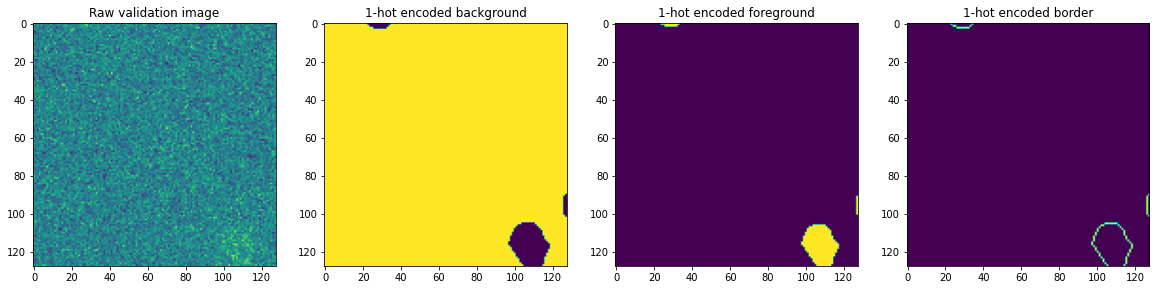

In [7]:
sl = 1
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sl,...,0], vmin=0, vmax=1)
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sl,...,1], vmin=0, vmax=1)
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sl,...,2], vmin=0, vmax=1)
plt.title('1-hot encoded border');

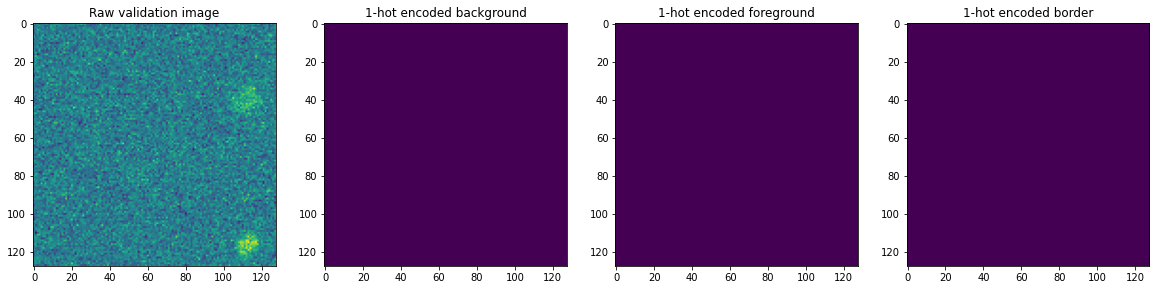

In [8]:
sl = -1
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sl,...,0])
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sl,...,0], vmin=0, vmax=1)
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sl,...,1], vmin=0, vmax=1)
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sl,...,2], vmin=0, vmax=1)
plt.title('1-hot encoded border');

In [9]:
train_batch_size = 128
train_steps_per_epoch = max(100, min(int(X.shape[0]/train_batch_size), 400))

In [10]:


conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=200, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=False)

vars(conf)



{'means': ['13.486088'],
 'stds': ['44.00652'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 200,
 'train_steps_per_epoch': 237,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

# <div style='color:red'>Tensorboard is not working!</div>

In [11]:
model_name = 'denoiseg_model'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.prepare_for_training()
model.keras_model._make_train_function()
model.keras_model._make_test_function()
model.keras_model._make_predict_function()
#model.prepare_for_training()
model.keras_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, None, 1 0                                            
__________________________________________________________________________________________________
down_level_0_no_0 (Conv2D)      (None, None, None, 3 320         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         down_level_0_no_0[0][0]          
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [15]:
nodes = [n.name for n in tf.get_default_graph().as_graph_def().node]
[k for k in nodes if 'group' in k]

['training/group_deps', 'group_deps', 'group_deps_1']

In [16]:
#loss = tf.get_default_graph().get_tensor_by_name("loss/mul:0")
#train_op = tfoptimizer.minimize(loss, name='train')
tf.global_variables_initializer()
tf.train.Saver().as_saver_def()

filename_tensor_name: "save/Const:0"
save_tensor_name: "save/control_dependency:0"
restore_op_name: "save/restore_all"
max_to_keep: 5
keep_checkpoint_every_n_hours: 10000.0
version: V2

In [17]:
tf.summary.FileWriter("logs", tf.get_default_graph())

In [18]:
with open('../resources/graph_2d.pb', 'wb') as f:
    f.write(tf.get_default_graph().as_graph_def().SerializeToString())

In [19]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['input',
 'down_level_0_no_0/random_uniform/shape',
 'down_level_0_no_0/random_uniform/min',
 'down_level_0_no_0/random_uniform/max',
 'down_level_0_no_0/random_uniform/RandomUniform',
 'down_level_0_no_0/random_uniform/sub',
 'down_level_0_no_0/random_uniform/mul',
 'down_level_0_no_0/random_uniform',
 'down_level_0_no_0/kernel',
 'down_level_0_no_0/kernel/Assign',
 'down_level_0_no_0/kernel/read',
 'down_level_0_no_0/Const',
 'down_level_0_no_0/bias',
 'down_level_0_no_0/bias/Assign',
 'down_level_0_no_0/bias/read',
 'down_level_0_no_0/convolution/dilation_rate',
 'down_level_0_no_0/convolution',
 'down_level_0_no_0/BiasAdd',
 'batch_normalization_1/Const',
 'batch_normalization_1/gamma',
 'batch_normalization_1/gamma/Assign',
 'batch_normalization_1/gamma/read',
 'batch_normalization_1/Const_1',
 'batch_normalization_1/beta',
 'batch_normalization_1/beta/Assign',
 'batch_normalization_1/beta/read',
 'batch_normalization_1/Const_2',
 'batch_normalization_1/moving_mean',
 'batch_norm

In [21]:
# save for prediction
import shutil
#shutil.rmtree("../resources/prediction")
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    tf.local_variables_initializer().run()
    tf.tables_initializer().run()
    #print(sess.graph.get_tensor_by_name('keras_learning_phase/input:0'))
    #sess.run(tf.variables_initializer([tf.compat.v1.get_variable("conv2d_1/bias:0")]))
    #sess.run(init)
    sess.run("init")
    model_input = tf.compat.v1.saved_model.build_tensor_info(sess.graph.get_tensor_by_name('input:0'))
    model_output = tf.compat.v1.saved_model.build_tensor_info(sess.graph.get_tensor_by_name('activation_19/Identity:0'))

    signature_definition = tf.compat.v1.saved_model.build_signature_def(
        inputs={"input": model_input},
        outputs={"output": model_output},
        method_name=tf.compat.v1.saved_model.signature_constants.PREDICT_METHOD_NAME)

    builder = tf.compat.v1.saved_model.Builder("../resources/prediction_2d")
    builder.add_meta_graph_and_variables(sess, [tf.compat.v1.saved_model.tag_constants.SERVING], signature_def_map={
        tf.compat.v1.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature_definition
    }, clear_devices=True)
    builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ../resources/prediction_2d/saved_model.pb
